In [15]:
from torch.utils.data import Dataset, DataLoader
from torch import nn, from_numpy, optim
import numpy as np

In [16]:
class customDataset(Dataset):

  def __init__(self,filepath):
    xy = np.loadtxt(filepath, delimiter=',',dtype=np.float32)
    self.len= xy.shape[0]
    self.x_data = from_numpy(xy[:,1:])
    self.x_data = np.where(self.x_data==-1,2,self.x_data) #change -1 to 2
    self.y_data = from_numpy(xy[:,[0]]).flatten().long()
    self.y_data = np.where(self.y_data==-1,0,self.y_data) # change -1 to 0


  def __getitem__(self, index):
    return self.x_data[index],self.y_data[index]

  def __len__(self):
    return self.len

In [17]:
Trdataset = customDataset('dota2Train.csv')
Tsdataset = customDataset('dota2Test.csv')

In [18]:
print(Trdataset.y_data.size)

train_loader = DataLoader(dataset=Trdataset,
                          batch_size=64,
                          shuffle=True,
                          )
test_loader = DataLoader(dataset=Tsdataset,
                          batch_size=64,
                          shuffle=True,
                          )


92650


In [25]:
class Model(nn.Module):

  def __init__(self):

    super(Model,self).__init__()
    self.l1 = nn.Linear(116,256)
    self.l2 = nn.Linear(256,128)
    self.l3 = nn.Linear(128,64)
    self.l4 = nn.Linear(64,32)
    self.l5 = nn.Linear(32,2)

    self.hidden = nn.Sequential(
        self.l1,
        nn.ReLU(),
        self.l2,
        nn.ReLU(),
        self.l3,
        nn.ReLU(),
        self.l4,
        nn.ReLU(),
        self.l5
       
            )
  

  def forward(self,x):
    x = self.hidden(x)
    return x

  

In [29]:
model = Model()

criterion = nn.CrossEntropyLoss()  
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(5):
  for i, data in enumerate(train_loader,0):
    inputs, labels = data
    y_pred = model(inputs)
    
    loss = criterion(y_pred,labels)
    
    if i % 10 ==0:
      print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Train Epoch: 0 | Batch Status: 0/92650 (0%) | Loss: 0.687192
Train Epoch: 0 | Batch Status: 20/92650 (1%) | Loss: 0.713664
Train Epoch: 0 | Batch Status: 40/92650 (1%) | Loss: 0.699623
Train Epoch: 0 | Batch Status: 60/92650 (2%) | Loss: 0.690019
Train Epoch: 0 | Batch Status: 80/92650 (3%) | Loss: 0.679102
Train Epoch: 0 | Batch Status: 100/92650 (3%) | Loss: 0.677589
Train Epoch: 0 | Batch Status: 120/92650 (4%) | Loss: 0.689609
Train Epoch: 0 | Batch Status: 140/92650 (5%) | Loss: 0.694548
Train Epoch: 0 | Batch Status: 160/92650 (6%) | Loss: 0.695631
Train Epoch: 0 | Batch Status: 180/92650 (6%) | Loss: 0.712864
Train Epoch: 0 | Batch Status: 200/92650 (7%) | Loss: 0.692304
Train Epoch: 0 | Batch Status: 220/92650 (8%) | Loss: 0.694447
Train Epoch: 0 | Batch Status: 240/92650 (8%) | Loss: 0.692748
Train Epoch: 0 | Batch Status: 260/92650 (9%) | Loss: 0.690040
Train Epoch: 0 | Batch Status: 280/92650 (10%) | Loss: 0.692927
Train Epoch: 0 | Batch Status: 300/92650 (10%) | Loss: 0.692

In [30]:
model.eval()
test_loss = 0
correct = 0

for i, data in enumerate(test_loader):
  inputs, labels = data
  y_pred = model(inputs)

  test_loss += criterion(y_pred, labels).item()

  pred = y_pred.data.max(1,keepdim=True)[1]
  #print(pred)
  correct += pred.eq(labels.data.view_as(pred)).cpu().sum()

test_loss /= len(test_loader.dataset)
print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')



Test set: Average loss: 0.0108, Accuracy: 5502/10294 (53%)


In [31]:
##KNN

def euclidean_distance(a, B):
    
    
   
    dist = []
   
    
    for i in B:      
        dist.append(np.sqrt(np.sum((i-a)**2)))
        
    
    
    
    return dist

def get_kneighbors(X_test, X_train, k, distance_metric=euclidean_distance):
    """
    Description: Returns the neighbors of X_test in X_train
    Input: X_test - test instances (list of instances or matrix)
           X_train - training instances (list of instances or matrix)
           k - k in kNN; #neighbors
           distance_metric - distance metric
    Output: index (array index or index in the input list) of the neighboring instances
    """
    
    """ ---- Beginning of code block (1) ---- """
    neighbors = []
    pairwise_dist = [distance_metric(x_test, X_train) for x_test in X_test]    
#     print(pairwise_dist)
    """ ---- End of code block (1) ---- """
    
    
    """ ---- Beginning of code block (2) ---- """
    for dist in pairwise_dist:
        dist_indexed = enumerate(dist)
        dist_indexed_sorted = sorted(dist_indexed, key=lambda x: x[1])[:k]
        
        neighbors_dist = [instance[1] for instance in dist_indexed_sorted]
        neighbors_index = [instance[0] for instance in dist_indexed_sorted]
        
        neighbors.append(neighbors_index)
    """ ---- End of code block (2) ---- """
        
    return np.array(neighbors)


def knn_clf(X_test, X_train, y_train, k=3, distance_metric=euclidean_distance):
    """
    Description: KNN Classification; classifies X_test according to (X_train, y_train)
    Input: X_test - test instances (list of instances or matrix)
           X_train - training instances (list of instances or matrix)
           y_train - training labels
           k - k in kNN; #neighbors
           distance_metric - distance metric
    Output: predictions
    """
    
    """ ---- Beginning of code block (3) ---- """
    ls_neighbors = get_kneighbors(X_test, X_train, k, distance_metric)
#   print(ls_neighbors)
#   print(type(ls_neighbors[1][0]))
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbors])) for neighbors in ls_neighbors])
    """ ---- End of code block (3) ---- """
    
    return y_pred 


In [55]:

data_tr = np.genfromtxt('dota2Train.csv', delimiter=',', skip_header=1)
data_ts = np.genfromtxt('dota2Test.csv', delimiter=',', skip_header=1)

#N_tr, d_tr = data_tr.shape
#print(N_tr)
#print(d_tr)
#N_ts, d_ts = data_ts.shape
#print(N_ts)
#print(d_ts)

X_tr = data_tr[:20000,1:]
X_tr = np.where(X_tr ==-1,2,X_tr)

Y_tr = data_tr[:20000,[0]].astype(np.int64).flatten()
Y_tr = np.where(Y_tr==-1,0,Y_tr)

X_ts = data_ts[:,1:]
X_ts = np.where(X_ts ==-1,2,X_ts)

Y_ts = data_ts[:,[0]].astype(np.int64).flatten()
Y_ts = np.where(Y_ts==-1,0,Y_ts)
print(X_tr.shape)
print(Y_tr.shape)


(20000, 116)
(20000,)


In [45]:
def get_accuracy(Y_true, Y_pred):
    """
    Measures the classification accuracy.
    Input: Y_true - true label vector (ground truth)
           Y_pred - predicted label vector
    return a floating point number representing accuracy (a single number of accuracy rate)
    """
    accuracy = Y_true == Y_pred
    
    
    return accuracy.sum()/len(Y_true)

[0.512872826192558, 0.5093753036043913, 0.5055863208005441, 0.5037404061012338, 0.5028660254541921, 0.5037404061012338, 0.5068493150684932, 0.5104439910618868, 0.5118041387350627, 0.5087923831730302, 0.5134557466239191, 0.5117069853298358, 0.514232973865734, 0.5162731953754979, 0.5177304964539007, 0.5138443602448266, 0.5172447294277664, 0.5169532692120858, 0.5203536383950258]


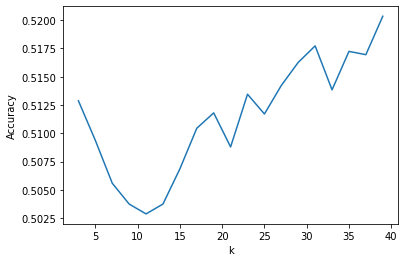

In [49]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

accuracies = []
for num in range(3,41,2):
    y_pred = knn_clf(X_ts,X_tr,Y_tr,k=num)
    accuracies.append(get_accuracy(Y_ts,y_pred))

plt.plot(range(3,41,2),accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")

print(accuracies)    

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, log_loss)

# Step 1: Get training and testing datasets
#X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.4, random_state=777)

# Data normalization
# normalizer = MinMaxScaler(feature_range=(0, 1))
# normalizer.fit(X_tr)
# X_tr_normalized = normalizer.transform(X_tr)
# X_ts_normalized = normalizer.transform(X_ts)

# Step 2: Use GridSearchCV to find optimal hyperparameter values
clf = RandomForestClassifier()
parameters = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
              'criterion': ['gini', 'entropy']}
gridsearch = GridSearchCV(clf, parameters, scoring='accuracy', cv=3)

gridsearch.fit(X_tr, Y_tr)
print(f'gridsearch.best_params_ = {gridsearch.best_params_}')

# Step 3: Get model with best hyperparameters
best_clf = gridsearch.best_estimator_

# Step 4: Get best model performance from testing set
y_pred = best_clf.predict(X_ts)
test_acc = accuracy_score(Y_ts, y_pred)
print(f'test_acc = {test_acc}')

gridsearch.best_params_ = {'criterion': 'entropy', 'n_estimators': 300}
test_acc = 0.5650442047993782
